In [12]:
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import cost_function
from database import CityLearnDatabase, SQLiteDatabase
from utilities import split_lines

In [13]:
formatted_name = {
    'marlisa':{True:r'$\mathrm{MARLISA_{RBC_{Basic}}}$',False:r'$\mathrm{MARLISA_{RBC_{Optimized}}}$'},
    'sac':{True:r'$\mathrm{SAC_{RBC_{Basic}}}$',False:r'$\mathrm{SAC_{RBC_{Optimized}}}$'},
    'basic_rbc':{True:r'$\mathrm{RBC_{Basic}}$',False:r'$\mathrm{RBC_{Basic}}$'},
    'optimized_rbc':{True:r'$\mathrm{RBC_{Optimized}}$',False:r'$\mathrm{RBC_{Optimized}}$'},
}
seasons = {
    'spring':(3,4,5),
    'summer':(6,7,8),
    'fall':(9,10,11),
    'winter':(12,1,2),
}
years = list(range(2014,2018))
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

# Reward Function Design
***
$E$ is an array of the district buildings' electricity demand, $n$ is the number of buildings in the district and $t$ is the current timestep.

1. __Default__
    $$
    r(t)^\textrm{def} = E(t)
    $$

2. __MARLISA__
    $$
    r(t)^\textrm{marl} = \textrm{sign}\left(r(t)^\textrm{def}\right) \times 0.01 \times \left|{r(t)^\textrm{def}}\right|^2 \times \textrm{max}\left(0, -\sum_{i=1}^{n-1}{r(t)^\textrm{def}_i}\right)
    $$

3. __SAC__
    $$
    r(t)^\textrm{sac} = \left[\textrm{min}\left(0,{r(t)_0^\textrm{def}}^3\right), \dots, \textrm{min}\left(0,{r(t)_{n-1}^\textrm{def}}^3\right)\right]
    $$

4. __Ramping Square__
    $$
    r(t)^\textrm{ramp} = \left[-\left(\left(\sum_{i=0}^{n-1}{r(t)^\textrm{def}_i} - \sum_{i=0}^{n-1}{r(t-1)^\textrm{def}_i}\right)^2\right)_0, \dots, -\left(\left(\sum_{i=0}^{n-1}{r(t)^\textrm{def}_i} - \sum_{i=0}^{n-1}{r(t-1)^\textrm{def}_i}\right)^2\right)_{n-1}\right] \div n
    $$

5. __Exponential__
    $$
    r(t)^\textrm{exp} = \left[\left(-e^{0.0002 \times \sum_{i=0}^{n-1}{-r(t)^\textrm{def}_i}}\right)_0, \dots, \left(-e^{0.0002 \times \sum_{i=0}^{n-1}{-r(t)^\textrm{def}_i}}\right)_{n-1}\right] \div n
    $$

    Where 0.0002 is a scaling factor to avoid high exponents defined as $\frac{\lambda}{50}$. We use $\lambda = 0.01$.

6. __Mixed__
    $$
    r(t)^\textrm{mix} = r(t)^\textrm{ramp} + r(t)^\textrm{exp}
    $$

# Simulation Analysis
***

### C8 
- training off-line from the fixed logs of an external behavior policy.The benchmark here is to learn a control law  from data generated by a sub-optimal reference controller, .e.g., a rule based controller, which is often available, essentially a system log. In addition to the control environment, datasets of various size, e.g.,two weeks, one months, 6 months should be provided that are generated with a known reference rule based controller. Then, the controllers can be evaluated on the ability to improve these baselines.

In [14]:
shared_directory = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/lab_computer/simulation_output_c8'
c8_database_filepath = os.path.join(shared_directory,'simulation.db')
figures_directory = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/CityLearn/figures'
# source_filepaths = [os.path.join(shared_directory,f'simulation_{i}.db') for i in range(1,41)]
# CityLearnDatabase.concatenate(c8_database_filepath,source_filepaths)
database = SQLiteDatabase(c8_database_filepath)
# database.execute_sql_from_file('schema.sql')

In [15]:
# metadata
metadata = database.query_table("""
SELECT
    s.id AS simulation_id,
    s.name AS simulation_name,
    e.id AS environment_id,
    a.name AS agent_name,
    AVG(a.seed) AS seed,
    AVG(a.basic_rbc) AS basic_rbc,
    AVG(a.exploration_period) AS exploration_period
FROM agent a
LEFT JOIN building b ON b.agent_id = a.id
LEFT JOIN environment e ON e.id = b.environment_id
LEFT JOIN simulation s ON s.id = e.simulation_id
GROUP BY
    s.id,
    e.id,
    a.name
""")
group_list = []

for i, (name, group) in enumerate(metadata.groupby(['agent_name','basic_rbc','exploration_period'])):
    group = group.copy()
    group.loc[:,'simulation_set'] = i
    group_list.append(group)

metadata = pd.concat(group_list,ignore_index=True)
metadata = metadata.sort_values(['simulation_set']).reset_index(drop=True)
display(metadata.head())

# storage capacity
query = """
SELECT
    b.id,
    0 AS "Cooling Storage (h)",
    0 AS "DHW Storage (h)",
    e.capacity AS "Electrical Storage (kW)",
    b.solar_power_installed AS "PV (kW)"
FROM building b
LEFT JOIN cooling_storage c ON c.building_id = b.id
LEFT JOIN dhw_storage d ON d.building_id = b.id
LEFT JOIN electrical_storage e ON e.building_id = b.id
WHERE environment_id = 1
"""
storage_data = database.query_table(query)
storage_data = storage_data.set_index('id')
storage_data = storage_data.round(0).astype(int)

,simulation_id,simulation_name,environment_id,agent_name,seed,basic_rbc,exploration_period,simulation_set
0,37,simulation_37,37,basic_rbc,0.0,1.0,0.0,0
1,38,simulation_38,38,basic_rbc,0.0,1.0,0.0,0
2,14,simulation_14,14,marlisa,0.0,0.0,744.0,1
3,16,simulation_16,16,marlisa,1.0,0.0,744.0,1
4,18,simulation_18,18,marlisa,2.0,0.0,744.0,1


In [16]:
# average weekly x electric consumption
columns = ['net_electric_consumption','electric_consumption_electric_storage','electric_consumption_cooling_storage','electric_consumption_dhw_storage']
plot_metadata = metadata[
    (metadata['agent_name'].isin(['marlisa','sac']))
    &(metadata['basic_rbc']==True)
].copy()
end_timestep = database.query_table('SELECT MAX(timestep) FROM timestep').iloc[0,0]
start_timestep = plot_metadata['exploration_period'].max() + 1
row_count = plot_metadata.groupby(['agent_name','basic_rbc']).size().shape[0]
column_count = len(seasons)
figsize = (3.2*column_count,1.5*row_count)

for column in columns:
    fig, axs = plt.subplots(row_count,column_count,figsize=figsize,sharey=True,sharex=True)

    for i, season in enumerate(seasons):
        for j, ((agent_name, basic_rbc), agent_group) in enumerate(plot_metadata.groupby(['agent_name','basic_rbc'])):

            for exploration_period, group in agent_group.groupby(['exploration_period']):
                environment_ids = tuple(group['environment_id'].tolist())
                query = f"""
                SELECT
                    t.day_type,
                    t.hour,
                    AVG(e.{column}) AS value
                FROM environment_timeseries e
                LEFT JOIN timestep t ON t.id = e.timestep_id
                WHERE t.timestep BETWEEN {start_timestep} AND {end_timestep}
                AND e.environment_id IN {environment_ids}
                AND t.month IN {seasons[season]}
                GROUP BY
                    t.day_type,
                    t.hour
                """
                plot_data = database.query_table(query)
                x, y = plot_data.index, plot_data['value']
                axs[j,i].plot(x,y,label=int(exploration_period))

            if j == 0:
                axs[j,i].set_title(f'{season.capitalize()}')
            else:
                axs[j,i].set_title(None)

            if i == 0:
                axs[j,i].set_ylabel(f'{formatted_name[agent_name][basic_rbc]}\n{"kWh"}')
            else:
                axs[j,i].set_ylabel(None)
            
            axs[j,i].xaxis.set_major_locator(ticker.MultipleLocator(base=24))
            axs[j,i].spines['top'].set_visible(False)
            axs[j,i].spines['right'].set_visible(False)

            if column != 'net_electric_consumption':
                axs[j,i].spines['bottom'].set_position('zero')
            else:
                pass

    axs[j,i].legend(
        title='Offline period',ncol=len(agent_group['exploration_period'].unique()),
        bbox_to_anchor=(0.5,0.09),bbox_transform=fig.transFigure,loc='upper center',framealpha=0,
    )
    fig.align_ylabels()
    plt.savefig(os.path.join(figures_directory,f'average_weekly_{column}.pdf'),bbox_inches='tight',facecolor='white')
    plt.close()

In [19]:
# annual net electric consumption snapshot
columns = ['net_electric_consumption',]
plot_metadata = metadata[metadata['agent_name'].isin(['marlisa','sac'])].copy()
end_timestep = database.query_table('SELECT MAX(timestep) FROM timestep').iloc[0,0]
row_count = plot_metadata.groupby(['agent_name','basic_rbc']).size().shape[0]
date_ranges = [pd.date_range(f'{i}-01-01 00:00:00',f'{i}-12-31 23:00:00',freq='H') for i in years]
timestamps = [t for d in date_ranges for t in d]
timestamps = pd.DataFrame({'timestamp':timestamps})
timestamps['timestep'] = timestamps.index + 1
relevant_years = [2014,2015]
first_year_start_timestep = 4345
days = 7
column_count = len(relevant_years)
figsize = (6*column_count,1.5*row_count)
fig, axs = plt.subplots(row_count,column_count,figsize=figsize,sharey=True,sharex='col')

for i, year in enumerate(relevant_years):
    start_timestep = i*8760 + first_year_start_timestep
    end_timestep = start_timestep + days*24

    for j, ((agent_name, basic_rbc), agent_group) in enumerate(plot_metadata.groupby(['agent_name','basic_rbc'])):
        plotted_flexibility = False

        for exploration_period, group in agent_group.groupby(['exploration_period']):
            environment_ids = tuple(group['environment_id'].tolist())
            query = f"""
            SELECT
                t.timestep,
                AVG(e.net_electric_consumption) AS net_electric_consumption,
                AVG(e.net_electric_consumption + e.electric_generation - (
                    e.electric_consumption_electric_storage 
                    + e.electric_consumption_cooling_storage 
                    + e.electric_consumption_dhw_storage
                )) AS electric_consumption_no_pv_no_storage,
                AVG(e.net_electric_consumption - (
                    e.electric_consumption_electric_storage 
                    + e.electric_consumption_cooling_storage 
                    + e.electric_consumption_dhw_storage
                )) AS electric_consumption_no_storage
            FROM environment_timeseries e
            LEFT JOIN timestep t ON t.id = e.timestep_id
            WHERE t.timestep BETWEEN {start_timestep} AND {end_timestep}
            AND e.environment_id IN {environment_ids}
            GROUP BY
                t.timestep
            """
            plot_data = database.query_table(query).iloc[0:int(days*24)]
            plot_data = plot_data.merge(timestamps,on='timestep',how='left')
            x, y = plot_data['timestamp'], plot_data['net_electric_consumption']

            if not plotted_flexibility:
                axs[j,i].plot(x,plot_data['electric_consumption_no_pv_no_storage'],color='black',linestyle='--',label='Without control & PV')
                # axs[j,i].plot(x,plot_data['electric_consumption_no_storage'],color='red',linestyle='--',label='No storage')
                plotted_flexibility = True
            else:
                pass

            axs[j,i].plot(x,y,label=int(exploration_period))

        axs[j,i].set_ylabel(f'{formatted_name[agent_name][basic_rbc]}\n{"kWh"}')
        axs[j,i].spines['top'].set_visible(False)
        axs[j,i].spines['right'].set_visible(False)
        axs[j,i].xaxis.set_major_locator(mdates.DayLocator(interval=1))
        axs[j,i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

        if i == 0:
            axs[j,i].set_ylabel(formatted_name[agent_name][basic_rbc])
        else:
            axs[j,i].set_ylabel(None)

        if j == 0:
            axs[j,i].set_title(int(year))
        else:
            axs[j,i].set_title(None)

        if j == row_count - 1:
            axs[j,i].set_xlabel('Date (mm-dd)')
        else:
            pass

axs[j,i].legend(ncol=6,bbox_to_anchor=(0.5,0.055),bbox_transform=fig.transFigure,loc='upper center',framealpha=0,)
fig.align_ylabels()
plt.savefig(os.path.join(figures_directory,f'net_electric_consumption_snapshot.pdf'),bbox_inches='tight',transparent=True)
plt.close()

In [18]:
# cost functions
plot_data_list = []

for i, ((simulation_set, exploration_period, agent_name, basic_rbc), group) in enumerate(metadata.groupby(['simulation_set','exploration_period','agent_name', 'basic_rbc'])):
    environment_ids = tuple(group['environment_id'].tolist())
    query = query = f"""
    SELECT
        t.timestep,
        AVG(e.net_electric_consumption) AS net_electric_consumption
    FROM environment_timeseries e
    LEFT JOIN timestep t ON t.id = e.timestep_id
    WHERE e.environment_id IN {environment_ids}
    GROUP BY
        t.timestep
    """
    plot_data = database.query_table(query)
    
    # cost functions
    plot_data['ramping_cost_function'] = cost_function.ramping(plot_data['net_electric_consumption'])
    plot_data['load_factor_cost_function'] = cost_function.load_factor(plot_data['net_electric_consumption'])
    plot_data['average_daily_peak_cost_function'] = cost_function.average_daily_peak(plot_data['net_electric_consumption'])
    # plot_data['annual_peak_demand_cost_function'] = cost_function.peak_demand(plot_data['net_electric_consumption'])
    plot_data['net_electric_consumption_cost_function'] = cost_function.net_electric_consumption(plot_data['net_electric_consumption'])
    plot_data['agent_name'] = agent_name
    plot_data['exploration_period'] = exploration_period
    plot_data['basic_rbc'] = basic_rbc
    plot_data['simulation_set'] = simulation_set
    plot_data_list.append(plot_data)

# calculate normalized cost
plot_data = pd.concat(plot_data_list,ignore_index=True)
plot_data = plot_data.drop(columns=['net_electric_consumption'])
cost_function_columns = [c for c in plot_data.columns if c.endswith('cost_function')]
id_vars = [c for c in plot_data.columns if c not in cost_function_columns]
plot_data = plot_data.melt(id_vars=id_vars,value_vars=cost_function_columns)
plot_data['variable'] += '_norm'
rbc_data = plot_data[plot_data['agent_name'].isin(['basic_rbc','optimized_rbc'])].copy()
rbc_data['basic_rbc'] = False
rbc_data.loc[rbc_data['agent_name']=='basic_rbc','basic_rbc'] = True
rbc_data = rbc_data.rename(columns={'value':'baseline_value'})
rbc_data = rbc_data[['timestep','variable','baseline_value','basic_rbc']].copy()
plot_data = plot_data.drop(rbc_data.index)
plot_data = pd.merge(plot_data,rbc_data,on=['timestep','variable','basic_rbc'],how='left')
plot_data['norm_value'] = plot_data['value']/plot_data['baseline_value']

# plot normalized cost functions
column_count = plot_data.groupby(['agent_name','basic_rbc']).size().shape[0]
row_count = len(cost_function_columns)
figsize = (3*column_count,1.25*row_count)
fig, axs = plt.subplots(row_count,column_count,figsize=figsize,sharey='row',sharex=True)

for i, ((agent_name, basic_rbc), group) in enumerate(plot_data.groupby(['agent_name','basic_rbc'])):
    for j, (variable, var_group) in enumerate(group.groupby(['variable'])):
        for exploration_period, env_group in var_group.groupby(['exploration_period']):
            x, y = env_group['timestep'], env_group['norm_value']
            axs[j,i].plot(x,y,label=int(exploration_period))

        axs[j,i].axhline(1,color='black',linestyle='--',)
        axs[j,i].spines['top'].set_visible(False)
        axs[j,i].spines['right'].set_visible(False)
        axs[j,i].set_xticks([i for i in range(1,int(8760*4),8760)])
        axs[j,i].set_xticklabels(years)
        # axs[j,i].xaxis.set_major_locator(ticker.MultipleLocator(8760))
        axs[j,i].legend().set_visible(False)

        if i == 0:
            ylabel = variable.replace('_cost_function_norm','').replace('_',' ').capitalize()
            ylabel = split_lines(ylabel,12)
            axs[j,i].set_ylabel(ylabel)
        else:
            axs[j,i].set_ylabel(None)

        if j == 0:
            axs[j,i].set_title(formatted_name[agent_name][basic_rbc])
        else:
            axs[j,i].set_title(None)

        if j == row_count - 1:
            axs[j,i].set_xlabel('Year')
        else:
            pass

axs[j,i].legend(
    ncol=len(plot_data['exploration_period'].unique()),
    bbox_to_anchor=(0.5,0.055),bbox_transform=fig.transFigure,loc='upper center',framealpha=0,
)
fig.align_ylabels()
plt.savefig(os.path.join(figures_directory,f'normalized_cost_function.pdf'),bbox_inches='tight',transparent=True)
plt.close()

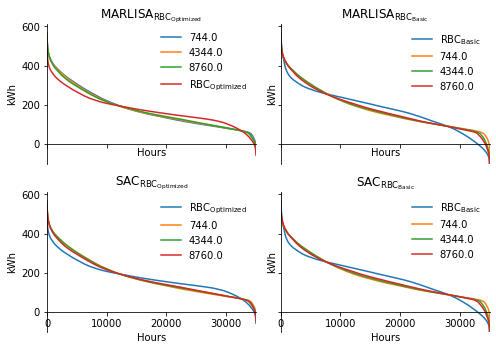

In [ ]:
# load duration curve
data_list = []

for i, ((simulation_set, exploration_period, agent_name, basic_rbc), group) in enumerate(metadata.groupby(['simulation_set','exploration_period','agent_name', 'basic_rbc'])):
    environment_ids = tuple(group['environment_id'].tolist())
    query = f"""
    SELECT
        AVG(e.net_electric_consumption) AS value
    FROM environment_timeseries e
    LEFT JOIN timestep t ON t.id = e.timestep_id
    WHERE e.environment_id IN {environment_ids}
    GROUP BY
        t.timestep
    ORDER BY
        AVG(e.net_electric_consumption) DESC
    """
    data = database.query_table(query)
    data['exploration_period'] = exploration_period
    data['agent_name'] = agent_name
    data['basic_rbc'] = basic_rbc
    data_list.append(data)

data = pd.concat(data_list,ignore_index=True)
plot_metadata = metadata[metadata['agent_name'].isin(['marlisa','sac'])].copy()
plot_metadata = plot_metadata.groupby(['agent_name','basic_rbc']).size().reset_index()
plot_metadata['plot_group'] = plot_metadata.index
data = data.merge(plot_metadata,on=['agent_name','basic_rbc'],how='left')
rbc_data = data[data['agent_name'].isin(['basic_rbc','optimized_rbc'])].copy()
rbc_data.loc[rbc_data['agent_name']=='optimized_rbc','basic_rbc'] = 0
data = data.drop(rbc_data.index)

for (basic_rbc, plot_group), _ in plot_metadata.groupby(['basic_rbc','plot_group']):
    plot_group_rbc_data = rbc_data[rbc_data['basic_rbc']==basic_rbc].copy()
    plot_group_rbc_data['plot_group'] = plot_group
    data = pd.concat([data,plot_group_rbc_data],ignore_index=True)

row_count = 2
column_count = 2
fig, axs = plt.subplots(row_count,column_count,figsize=(3.5*column_count,2.5*row_count),sharey=True,sharex=True)

for ax, (plot_group, group) in zip(fig.axes,data.groupby(['plot_group'])):
    ax_metadata = plot_metadata[plot_metadata['plot_group']==plot_group].iloc[0]
    
    for (agent_name, basic_rbc, exploration_period), plot_data in group.groupby(['agent_name','basic_rbc','exploration_period']):
        plot_data = plot_data.iloc[0:].copy()
        x, y = plot_data.reset_index().index, plot_data['value']
        label = formatted_name[agent_name][basic_rbc] if exploration_period == 0 else exploration_period
        ax.plot(x,y,label=label)
    
   
    ax.set_title(formatted_name[ax_metadata['agent_name']][ax_metadata['basic_rbc']])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.set_ylabel('kWh')
    ax.set_xlabel('Hours')
    ax.legend(loc='upper right',framealpha=0)

plt.tight_layout()
plt.savefig(f'figures/load_duration_curve.pdf',bbox_inches='tight',transparent=True)
plt.show()
# plt.close()
